In [1]:
import time
t0=time.time()
import os
import scipy.io
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.utils.data as Data
from sklearn.model_selection import train_test_split

path = "../trial/"
files = os.listdir(path)

#files_train = os.listdir(path_train)
#files_test = os.listdir(path_test)
    
x_train=[]
y_train=[]
x_test=[]
y_test=[]

for folder in files:   #各資料夾
    if os.path.isfile(os.path.join(path,folder)):
        continue
    files=os.listdir(path+folder) # 返回資料夾中的 資料或資料夾
    for file in files:
        #print file
        first=1
        if not os.path.isdir(file):
            f=open(path+folder+"/"+file)
            mat=scipy.io.loadmat(f)
            arr=mat['x']
            #print ('arr_shape', arr.shape)
            for i in range(1):
                for j in range(64):
                    tmp_arr=arr[i][j]
                    maxi=np.max(tmp_arr)
                    mini=np.min(tmp_arr)
                    for k in range(1760): # arr.shape[2]
                        if first == 1:
                            std=np.zeros((64,1760)) # arr.shape[2]
                            first = 0
                        std[j][k]=(arr[i][j][k]-mini)/(maxi-mini)
            x_train.append(np.array(std)) 
            y_train.append(int(folder))


In [2]:
x=np.asarray(x_train) 
y_train=np.asarray(y_train)
#x_test=np.asarray(x_test) 
#y_test=np.asarray(y_test)

y_mid=[]
x, tmp, y_train, tmp = train_test_split(x, y_train, test_size=0, random_state=42)

for i in range(y_train.shape[0]):
    if y_train[i] == 0 or y_train[i] == 1 or y_train[i] == 2 or y_train[i] == 3:
        y_mid.append(0)
    elif y_train[i] == 4 or y_train[i] == 5 or y_train[i] == 6 or y_train[i] == 7:
        y_mid.append(1)
    elif y_train[i] == 8 or y_train[i] == 9 or y_train[i] == 10 or y_train[i] == 11:
        y_mid.append(2)

y_mid=np.asarray(y_mid)
y=y_train

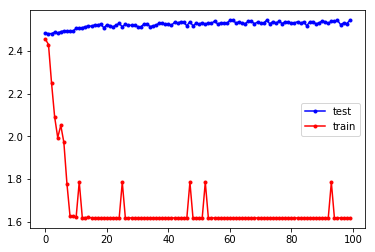

testing best acc:  14.8148148148


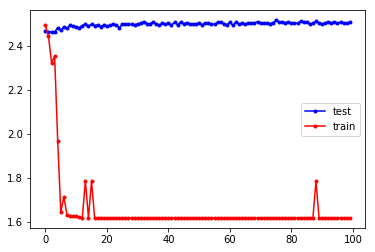

testing best acc:  22.2222222222


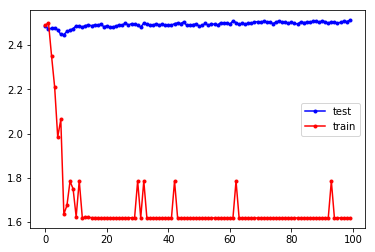

testing best acc:  16.6666666667


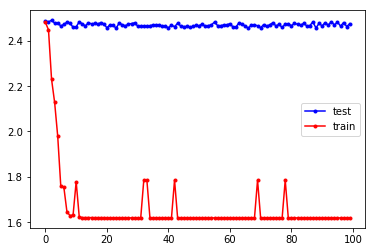

testing best acc:  18.5185185185


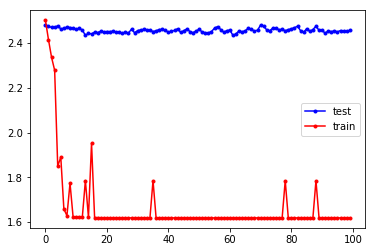

testing best acc:  22.2222222222


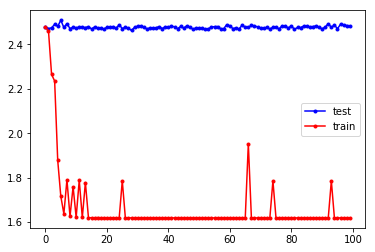

testing best acc:  16.6666666667


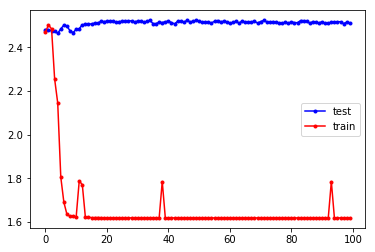

testing best acc:  11.1111111111


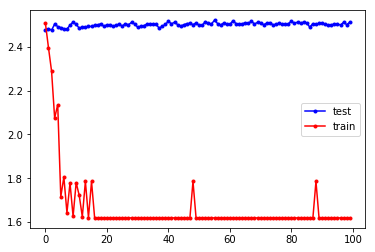

testing best acc:  14.8148148148


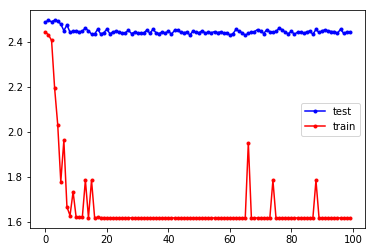

testing best acc:  24.0740740741


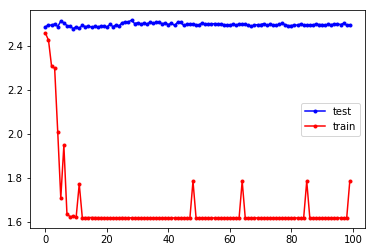

testing best acc:  12.962962963
total acc:  17.4074074074
time:  0.457004004982


In [3]:
#from __future__ import division
#from __future__ import print_function
#%%
import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import scipy.io
from model import Fully_Conv, EEGNet
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import pandas as pd
from sklearn.model_selection import KFold
kf=KFold(n_splits=10, shuffle=True)
%matplotlib inline
warnings.filterwarnings("ignore")
global total_acc
global total_acc1
total_acc1 = 0

sec=3
cut=1
idxs=0
times=1
for train_index, test_index in kf.split(x):
    xx_train, xx_test = x[train_index], x[test_index]
    yy_mid_train, yy_mid_test = y_mid[train_index], y_mid[test_index]
    yy_train, yy_test = y[train_index], y[test_index]
    x_train=[]
    y_train=[]
    x_test=[]
    y_test=[]
    y_mid_train=[]
    y_mid_test=[]

    
    for i in range(1):
        for j in range(xx_train.shape[0]):
            tmp_x = xx_train[j]
            x_train.append(tmp_x[:,xx_train.shape[2]-3*256:xx_train.shape[2]])
            y_mid_train.append(yy_mid_train[j])
            y_train.append(yy_train[j])
        for j in range(xx_test.shape[0]):
            tmp_x = xx_test[j]
            x_test.append(tmp_x[:,xx_train.shape[2]-3*256:xx_train.shape[2]])
            y_test.append(yy_test[j])
            y_mid_test.append(yy_mid_test[j])
   
    
    x_train=np.asarray(x_train)
    y_train=np.asarray(y_train)
    y_mid_train=np.asarray(y_mid_train)
    x_test=np.asarray(x_test)
    y_test=np.asarray(y_test)
    y_mid_test=np.asarray(y_mid_test)
    
    loss_list=[]
    train_loss=[]
    
    
    # Training settings
    parser = argparse.ArgumentParser()
    parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training.')
    parser.add_argument('--fastmode', action='store_true', default=False, help='Validate during training pass.')
    parser.add_argument('--sparse', action='store_true', default=False, help='GAT with sparse version or not.')
    parser.add_argument('--seed', type=int, default=72, help='Random seed.')
    parser.add_argument('--epochs', type=int, default=10000, help='Number of epochs to train.')
    parser.add_argument('--lr', type=float, default=0.005, help='Initial learning rate.')
    parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay (L2 loss on parameters).')
    parser.add_argument('--hidden', type=int, default=8, help='Number of hidden units.')
    parser.add_argument('--nb_heads', type=int, default=8, help='Number of head attentions.')
    parser.add_argument('--dropout', type=float, default=0.6, help='Dropout rate (1 - keep probability).')
    parser.add_argument('--alpha', type=float, default=0.2, help='Alpha for the leaky_relu.')
    parser.add_argument('--patience', type=int, default=100, help='Patience')

    #args = parser.parse_args()
    args = parser.parse_args(args=[])
    args.cuda = not args.no_cuda and torch.cuda.is_available()

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)


    train_DATADIR = "/train"
    test_DATADIR = "/test"
    CATEGORIES = ["0", "1", "2"]

    training_data = []
    training_data_label = []
    testing_data = []
    testing_data_label = []

   


    training_data = x_train
    testing_data = x_test
    training_data_label = y_train
    testing_data_label = y_test

    #acc_file=open("acc_sX_train_6sec_ov0.5sec_nolongstim.txt","w")


    class TrainDataset(Dataset):
        def __init__(self):
            self.len = len(training_data)
            self.train_data = training_data
            self.train_label = training_data_label


        def __getitem__(self, index):
            data = self.train_data[index]
            label = self.train_label[index]



            return data, label

        def __len__(self):
            return self.len

    class TestDataset(Dataset):
        def __init__(self):
            self.len = len(testing_data)
            self.test_data = testing_data
            self.test_label = testing_data_label


        def __getitem__(self, index):
            tdata = self.test_data[index]
            tlabel = self.test_label[index]

            return tdata, tlabel

        def __len__(self):
            return self.len

    train_dataset = TrainDataset()
    test_dataset = TestDataset()
    train_loader = DataLoader(dataset=train_dataset,batch_size=8,shuffle=True) #no slide data: batch=25
    test_loader = DataLoader(dataset=test_dataset,shuffle=False)

    model = Fully_Conv().cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    acc=[]

   

    #train
    def train(net, epoch):
        net.train()
        Tcorrect=0
        Tnum = 0
        global Tbest_acc


        for batch_idx, (data, label) in enumerate(train_loader, 0):
            if torch.cuda.is_available():
                labels, datas = label.cuda(), data.cuda()
            labels, datas = Variable(labels), Variable(datas.type(torch.cuda.FloatTensor))
            optimizer.zero_grad()
            y_pred = net(datas)
            #print 'data',datas.shape
            #print 'pred_shape',y_pred.shape, 'label_shape',labels.shape
            #print 'pred',y_pred, 'label',labels
            #print "\n"
            loss = criterion(y_pred, labels)
            Tpred = y_pred.data.max(1, keepdim=True)[1]
            Tcorrect += Tpred.eq(labels.data.view_as(Tpred)).cpu().sum()
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
           
    def test(net):
        net.eval()
        test_loss = 0
        correct = 0
        A=[]
        B=[]
        num=0
        global best_acc


        idx = 0
        for tdata, tlabel in test_loader:
            if torch.cuda.is_available():
                tlabels, tdatas = tlabel.cuda(), tdata.cuda()

            tlabels, tdatas = Variable(tlabels), Variable(tdatas.type(torch.cuda.FloatTensor))
            ty_pred = net(tdatas) #150, 12
            #sum up batch loss
            test_loss += F.cross_entropy(ty_pred, tlabels, size_average=False).item()
            #get the index of the max log-prob
            pred = ty_pred.data.max(1, keepdim=True)[1] #150,1
            

            idx = idx + 1
            correct += pred.eq(tlabels.data.view_as(pred)).cpu().sum() #tlabels 150
            A.append(tlabel.item())
            B.append(pred.item())
            
        test_loss /= len(test_loader.dataset)
        loss_list.append(test_loss)


        if 100. * correct / len(test_loader.dataset) > best_acc:
            best_acc = float(100 * correct) / float(len(test_loader.dataset))
            #print "epoch ", epoch, "best test acc:", best_acc




        ac=100. * correct / len(test_loader.dataset)
        ac=str(ac.item())
        acc.append(ac) 


    global Tbest_acc
    Tbest_acc = 0
    global best_acc
    best_acc = 0
    
    for epoch in range(0,100):
        train(model, epoch)
        test(model)
   
    
    df=pd.DataFrame({'x':range(len(loss_list)),'test':loss_list,'train':train_loss})
    plt.plot('x','test',data=df,marker='.',color='blue')
    plt.plot('x','train',data=df,marker='.',color='red')
    plt.title=('test loss/ epoches')
    plt.ylabel=('test loss')
    plt.legend()
    plt.savefig('./image/'+str(sec)+'s_'+str(cut)+'cut/'+'last'+'/'+'stage1-'+str(idxs)+'.png')
    pylab.show()

    
    

    
    
    print 'testing best acc: ', best_acc
    total_acc1 = total_acc1 + best_acc
    idxs+=1
    
print 'total acc: ', float(total_acc1)/(10.0)
print 'time: ', float((time.time()-t0)/3600.0)



In [4]:
print 'total acc: ', float(total_acc1)/(10.0)

total acc:  17.4074074074
